In [1]:
# Imports libs
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms
import pandas as pd
import cv2
import torchvision
import torch
import time
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import numpy as np
import copy
import random
from pprint import pprint
import copy
import yaml
from pose_hrnet import get_pose_net

In [2]:
!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [3]:
!pip install torchmetrics

In [4]:
import torch
from torchmetrics.detection import MeanAveragePrecision
print(torch.__version__)

1.10.0+cu113


In [5]:
# Constants
INPUT_MODE_AOLP_DOLP = 4
INPUT_MODE_Q0_ONLY = 3
INPUT_MODE_AOP_DOP_GLARE = 2
INPUT_MODE_STOKES = 1
INPUT_MODE_DEG = 0
INPUT_MODES = ["DEG","STOKES","AOLP_DOLP_GLARERED", "Q0_ONLY", "AOLP_DOLP"]
INPUT_MODES_NUM = 5
TRANSFORMS_NUM = 6
TRANSFORMS = ["Rotation","Flip", "Noise", "Blur", "Common_rotation", "Common_flip"]
TRANSFORM_ROT = 0
TRANSFORM_FLIP = 1
TRANSFORM_NOISE = 2
TRANSFORM_BLUR = 3
TRANSFORM_COMMON_ROT = 4
TRANSFORM_COMMON_FLIP = 5

In [6]:
#Helper functions
# Returns the image with any depth (can be a image with float values)
def readImage(sFilePath):
    
    aImage = cv2.imread(sFilePath,cv2.IMREAD_ANYDEPTH)
    
    return aImage

# Giving an angle (in degrees) and a image, returns the image rotated  and the matrix used in the rotation
def rotateImages(fDeg,aImages):
    iHeight = aImages.shape[1]
    iWidth = aImages.shape[2]
    tCenter = (iWidth/2,iHeight/2)
    aRotateMatrix = cv2.getRotationMatrix2D(tCenter,fDeg*180/np.pi,scale= 1)
    for i in range(aImages.shape[0]):
        aImages[i,:,:] = cv2.warpAffine(src=aImages[i,:,:], M=aRotateMatrix, dsize=(iWidth,iHeight))
    return aImages, aRotateMatrix

# Giving a rotation matrix and a annotation series, rotates the coordinates of the annotations  
def rotateCoordinates(aRotationMatrix, lAnnotation, iHeight, iWidth):
    lDeleteIds = []
    # Get every point annotated
    for i, dAnnotation in enumerate(lAnnotation):
        dPoints = dAnnotation["points"]
        fX1 = dPoints["x1"]
        fX2 = dPoints["x2"]
        fY1 = dPoints["y1"]
        fY2 = dPoints["y2"]
        # Rotate every corner of BB
        aPoints = np.array([ [[fX1,fY1]], [[fX2,fY2]] , [[fX1,fY2]], [[fX2,fY1]] ])
        # Rotate points using the matrix given
        aRotatedPoints = cv2.transform(aPoints,aRotationMatrix)
        # If any point is out of the image delete the annotation point
        if (np.sum(aRotatedPoints < 0) + np.sum(aRotatedPoints[:,0,0]> iWidth-1) + np.sum(aRotatedPoints[:,0,1] > iHeight-1))>0:
            lDeleteIds.append(i)
        else:
            # Save rotated points
            fRotX1 = aRotatedPoints[0,0,0]
            fRotY1 = aRotatedPoints[0,0,1]
            fRotX2 = aRotatedPoints[1,0,0]
            fRotY2 = aRotatedPoints[1,0,1]
            fRotX3 = aRotatedPoints[2,0,0]
            fRotY3 = aRotatedPoints[2,0,1]
            fRotX4 = aRotatedPoints[3,0,0]
            fRotY4 = aRotatedPoints[3,0,1]
            # Change BB rotated coordinates 
            dPoints["x1"] = min(fRotX1,fRotX2,fRotX3,fRotX4)
            dPoints["x2"] = max(fRotX1,fRotX2,fRotX3,fRotX4)
            dPoints["y1"] = min(fRotY1,fRotY2,fRotY3,fRotY4)
            dPoints["y2"] = max(fRotY1,fRotY2,fRotY3,fRotY4)
            
    lAnnotation = np.array(lAnnotation)
    lAnnotation = list(np.delete(lAnnotation,lDeleteIds))
    return lAnnotation

# Giving a polarization image, where each pixel is representated by 4 values (0º,45º,90º,135º) 
# returns AoLP and DoLP and GlareReduced images (normalized to 0..1 values) related to the input image
def getRelatedImages(aImage, iInputImageType, bSave = False):
    # Get values of each degree of each pixel
    aDeg0 = aImage[1::2,1::2]
    aDeg45 = aImage[::2,1::2]
    aDeg90 = aImage[::2,::2]
    aDeg135 = aImage[1::2,::2]
    
    # Same angle images
    if iInputImageType == INPUT_MODE_Q0_ONLY:
        # Add new axis
        aDeg0 = aDeg0[np.newaxis, ...]
        # Concatenate to have 3 channels
        aImages = np.concatenate((aDeg0,aDeg0,aDeg0),axis = 0)
        # Normalize to [0,1] range
        aImages /= 255.
        return aImages
        
    # Get different angle images
    if iInputImageType == INPUT_MODE_DEG:
        # Add new axis
        aDeg0 = aDeg0[np.newaxis, ...]
        aDeg45 = aDeg45[np.newaxis, ...]
        aDeg90 = aDeg90[np.newaxis, ...]
        aDeg135 = aDeg135[np.newaxis, ...]
        
        # Concatenate
        aImages = np.concatenate((aDeg0,aDeg45,aDeg90),axis = 0)
        # Normalize to [0,1] range
        aImages /= 255.
        return aImages

    # Generate stokes images
    aStokesS0 = aDeg90 + aDeg0
    aStokesS1 = aDeg0 - aDeg90
    aStokesS2 = aDeg45 - aDeg135
    
    # Get different stokes images
    if iInputImageType == INPUT_MODE_STOKES:
        # Add new axis
        aStokesS0 = aStokesS0[np.newaxis, ...]
        aStokesS1 = aStokesS1[np.newaxis, ...]
        aStokesS2 = aStokesS2[np.newaxis, ...]
        
        # Normalize
        aStokesS0 /= 255*2
        aStokesS1 /= 255
        aStokesS2 /= 255
        # Concatenate
        aImages = np.concatenate((aStokesS0,aStokesS1,aStokesS2),axis = 0)

        return aImages
        
    # Generate AoLP
    aAoP = np.arctan2(aStokesS2,aStokesS1)
    aAoP %= 2*np.pi
    aAoP /= 2
    # Normalize AoLP
    aAoP /= np.pi
    
    if bSave:
        cv2.imwrite("AoP.png", aAoP*255)
    # Add a dimension
    aAoP = aAoP[np.newaxis,...]
    
    
    # Add new axis
    aDeg0 = aDeg0[..., np.newaxis]
    aDeg45 = aDeg45[..., np.newaxis]
    aDeg90 = aDeg90[..., np.newaxis]
    aDeg135 = aDeg135[..., np.newaxis]
    
    # Generate GlareRed
    aAllConcat = np.concatenate((aDeg0,aDeg45,aDeg90,aDeg135), axis = 2)
    aGlareRed = np.amin(aAllConcat,axis = 2)
    # Normalize GlareRed image
    aGlareRed /= 255.
    if bSave:
        cv2.imwrite("GlareRed.png", aGlareRed*255)
    # Add a dimension
    aGlareRed = aGlareRed[np.newaxis,...]
    
    
    # Generate DoLP   
    aDoP = np.full_like(aStokesS0, fill_value=0)
    aMask = aStokesS0 != 0
    aDoP[aMask] = np.sqrt(aStokesS1*aStokesS1 + aStokesS2*aStokesS2)[aMask] / aStokesS0[aMask]
    # Already with values in range 0..1, no normalization needed
    
    if bSave:
        cv2.imwrite("DoP.png", aDoP*255)
    # Add a dimension
    aDoP = aDoP[np.newaxis,...]
    
    if iInputImageType == INPUT_MODE_AOLP_DOLP:
        # Create empty channel and concatenate
        aEmptyChannel = np.zeros(aDoP.shape)
        aImages = np.concatenate((aAoP, aDoP, aEmptyChannel), axis = 0)
        
        return aImages
    
    
    # Concatenate
    aImages = np.concatenate((aAoP,aDoP,aGlareRed),axis = 0)
    
    return aImages



# Giving a polarization image (each pixel contains 4 values of different angles), flips the polarization (swaping values related to 45º and 135º)
def flipPolarizationImage(aImage):
    a = aImage[::2,1::2].copy()
    aImage[::2,1::2] = aImage[1::2,::2]
    aImage[1::2,::2] = a

# Giving a polarization image (each pixel contains 4 values of different angles), flips the image taking into account tha 4 values of each pixel,
# flip mode can be indicated in iMode argument (0 for horizontal, 1 for vertical and other value for horizontal and vertical)
def flipQuadrantImage(aImage,iMode):
    iHeight = aImage.shape[0] 
    iWidth = aImage.shape[1]
    
    # Horizontal
    if iMode == 0:
        # Deg 0
        aImage[1::2,1::2] = aImage[1::2,iWidth-1::-2]
        # Deg 45
        aImage[::2,1::2] = aImage[::2,iWidth-1::-2]
        # Deg 90
        aImage[::2,::2] = aImage[::2,iWidth-2::-2]
        # Deg 135
        aImage[1::2,::2] = aImage[1::2,iWidth-2::-2]
    # Vertical
    elif iMode == 1:
        # Deg 0
        aImage[1::2,1::2] = aImage[iHeight-1::-2,1::2]
        # Deg 45
        aImage[::2,1::2] = aImage[iHeight-2::-2,1::2]
        # Deg 90
        aImage[::2,::2] = aImage[iHeight-2::-2,::2]
        # Deg 135
        aImage[1::2,::2] = aImage[iHeight-1::-2,::2]
    # Horizontal and vertical
    else:
        # Deg 0
        aImage[1::2,1::2] = aImage[iHeight-1::-2,iWidth-1::-2]
        # Deg 45
        aImage[::2,1::2] = aImage[iHeight-2::-2,iWidth-1::-2]
        # Deg 90
        aImage[::2,::2] = aImage[iHeight-2::-2,iWidth-2::-2]
        # Deg 135
        aImage[1::2,::2] = aImage[iHeight-1::-2,iWidth-2::-2]

In [7]:
# Giving 4 points coordinates, returns the oriented BBox coordinates related to those points
def getOrientedBBoxPoints(lPoints):
    iX1, iY1, iX2, iY2, iX3, iY3, iX4, iY4 = lPoints
    
    if iX4 == iX3:        
        fSlope1 = None
    else:
        fSlope1 = (iY4 - iY3)/(iX4 - iX3)
    
    if iX2 == iX1:
        fSlope2 = None
    else:
        fSlope2 = (iY2 - iY1)/(iX2 - iX1)
        
    if fSlope1 != None:
        iC1 = fSlope1*(-iX1) + iY1
        iC2 = fSlope1*(-iX2) + iY2
    
    if fSlope2 != None:
        iC3 = fSlope2*(-iX3) + iY3
        iC4 = fSlope2*(-iX4) + iY4
    
    # Intersect point between line 1 and line 4
    if fSlope1 == None:
        fNewX1 = iX1
        fNewY1 = fSlope2*fNewX1 + iC4
    elif fSlope2 == None:
        fNewX1 = iX4
        fNewY1 = fSlope1*fNewX1 + iC1
    else:
        fNewX1 = (iC4 - iC1)/(fSlope1 - fSlope2)
        fNewY1 = fSlope1*fNewX1 + iC1
        
    # Intersect point between line 1 and line 3
    if fSlope1 == None:
        fNewX2 = iX1
        fNewY2 = fSlope2*fNewX2 + iC3
    elif fSlope2 == None:
        fNewX2 = iX3
        fNewY2 = fSlope1*fNewX2 + iC1
    else:
        fNewX2 = (iC3 - iC1)/(fSlope1 - fSlope2)
        fNewY2 = fSlope1*fNewX2 + iC1
    
    # Intersect point between line 2 and line 3
    if fSlope1 == None:
        fNewX3 = iX2
        fNewY3 = fSlope2*fNewX3 + iC3
    elif fSlope2 == None:
        fNewX3 = iX3
        fNewY3 = fSlope1*fNewX3 + iC2
    else:
        fNewX3 = (iC3 - iC2)/(fSlope1 - fSlope2)
        fNewY3 = fSlope1*fNewX3 + iC2
    
    # Intersect point between line 2 and line 4
    if fSlope1 == None:
        fNewX4 = iX2
        fNewY4 = fSlope2*fNewX4 + iC4
    elif fSlope2 == None:
        fNewX4 = iX4
        fNewY4 = fSlope1*fNewX4 + iC2
    else:
        fNewX4 = (iC4 - iC2)/(fSlope1 - fSlope2)
        fNewY4 = fSlope1*fNewX4 + iC2
    

    return (fNewX1,fNewY1,fNewX2,fNewY2,fNewX3,fNewY3,fNewX4,fNewY4)

In [8]:
# Giving 4 points coordinates of a oriented BBox, returns the horizontally aligned BBox coordinates related to those points
def getHorizontalBBox(lPoints,iHeight,iWidth):
    fX1, fY1, fX2, fY2, fX3, fY3, fX4, fY4 = lPoints
    
    
    fNewX1 = max(0,min(fX1,fX2,fX3,fX4))
    fNewY1 = max(0,min(fY1,fY2,fY3,fY4))
    fNewX2 = min(iWidth - 1,max(fX1,fX2,fX3,fX4))
    fNewY2 = min(iHeight - 1,max(fY1,fY2,fY3,fY4))
    
    return (fNewX1,fNewY1,fNewX2,fNewY2)

In [9]:
# Giving a rotation matrix and a annotation list, rotates the coordinates of the annotations            
def rotateOrientedCoordinates(aRotationMatrix, lAnnotations, iHeight, iWidth):
    lDeleteIds = []

    # Get every point annotated
    for i, dAnnotation in enumerate(lAnnotations):
        dPoints = dAnnotation["points"]
        fX1 = dPoints[0]
        fY1 = dPoints[1]
        fX2 = dPoints[2]
        fY2 = dPoints[3]
        fX3 = dPoints[4]
        fY3 = dPoints[5]
        fX4 = dPoints[6]
        fY4 = dPoints[7]
        
        # Rotate every point
        aPoints = np.array([ [[fX1,fY1]], [[fX2,fY2]] , [[fX3,fY3]], [[fX4,fY4]] ])
        # Rotate points using the matrix given
        aRotatedPoints = cv2.transform(aPoints,aRotationMatrix)
        # If any point is out of the image delete the annotation point
        if (np.sum(aRotatedPoints < 0) + np.sum(aRotatedPoints[:,0,0]> iWidth-1) + np.sum(aRotatedPoints[:,0,1] > iHeight-1))>0:
            lDeleteIds.append(i)
        else:
            # Save rotated points
            fRotX1 = aRotatedPoints[0,0,0]
            fRotY1 = aRotatedPoints[0,0,1]
            fRotX2 = aRotatedPoints[1,0,0]
            fRotY2 = aRotatedPoints[1,0,1]
            fRotX3 = aRotatedPoints[2,0,0]
            fRotY3 = aRotatedPoints[2,0,1]
            fRotX4 = aRotatedPoints[3,0,0]
            fRotY4 = aRotatedPoints[3,0,1]
            # Change rotated coordinates 
            dPoints[0] = fRotX1
            dPoints[1] = fRotY1
            dPoints[2] = fRotX2
            dPoints[3] = fRotY2
            dPoints[4] = fRotX3
            dPoints[5] = fRotY3
            dPoints[6] = fRotX4
            dPoints[7] = fRotY4
            
    lAnnotations = np.array(lAnnotations)
    lAnnotations = list(np.delete(lAnnotations,lDeleteIds))
    
    return lAnnotations

In [10]:
# Giving a annotation list, the original images height and width and the new height and width, scales the coordinates of the annotations            
def scaleOrientedAnnotations(lAnnotations, iHeight, iWidth, iNewHeight, iNewWidth):
    # Calculate scale ratios
    fScaleHeight = iNewHeight / iHeight
    fScaleWidth = iNewWidth / iWidth

    # Get every point annotated
    for i, dAnnotation in enumerate(lAnnotations):
        dPoints = dAnnotation["points"]
        dPoints[0] *= fScaleWidth
        dPoints[1] *= fScaleHeight
        dPoints[2] *= fScaleWidth
        dPoints[3] *= fScaleHeight
        dPoints[4] *= fScaleWidth
        dPoints[5] *= fScaleHeight
        dPoints[6] *= fScaleWidth
        dPoints[7] *= fScaleHeight
    
    return lAnnotations

In [11]:
# Giving a oriented BBox of a ellipse returns the best horizontal BBox
def getHorizontalPointsOfEllipse(lOrientedBBoxPoints,  iHeight, iWidth):
    
    # Get ellipse's diagonal points
    fX1, fY1, fX2, fY2, fX3, fY3, fX4, fY4 = lOrientedBBoxPoints
    #print(lOrientedBBoxPoints)
    
    fEllipseX1 = fX1 + (fX2 - fX1)/2
    fEllipseX2 = fX2 + (fX3 - fX2)/2
    fEllipseX3 = fX3 + (fX4 - fX3)/2
    fEllipseX4 = fX4 + (fX1 - fX4)/2
   
    fEllipseY1 = fY1 + (fY2 - fY1)/2
    fEllipseY2 = fY2 + (fY3 - fY2)/2
    fEllipseY3 = fY3 + (fY4 - fY3)/2
    fEllipseY4 = fY4 + (fY1 - fY4)/2
    
    #print((fEllipseX1,fEllipseY1,fEllipseX2,fEllipseY2,fEllipseX3,fEllipseY3, fEllipseX4, fEllipseY4))
    
    # Get ellipse diagonals
    fA = np.sqrt((fEllipseX3-fEllipseX1)**2 + (fEllipseY3-fEllipseY1)**2)
    fB = np.sqrt((fEllipseX4-fEllipseX2)**2 + (fEllipseY4-fEllipseY2)**2)
    # Get radiuses
    fA /= 2
    fB /= 2
    
    # Set A bigger diagonal radius and calculate angle of longest diagonal
    if fB>fA:
        fA,fB = fB,fA
        if fEllipseX4 == fEllipseX2:
            fAngle = np.pi/2
        else:
            fAngle = np.arctan((fEllipseY4-fEllipseY2)/(fEllipseX4-fEllipseX2))
    else:
        if fEllipseX3 == fEllipseX1:
            fAngle = np.pi/2
        else:
            fAngle = np.arctan((fEllipseY3-fEllipseY1)/(fEllipseX3-fEllipseX1))
    
    # Get ellipse center
    fCenterX = fEllipseX1 + (fEllipseX3 - fEllipseX1)/2
    fCenterY = fEllipseY1 + (fEllipseY3 - fEllipseY1)/2
    
    # Get BBox coordinates
    fXmax = np.sqrt((fA * np.cos(fAngle))**2 + (fB*np.sin(fAngle))**2) + fCenterX
    fYmax = np.sqrt((fA * np.sin(fAngle))**2 + (fB*np.cos(fAngle))**2) + fCenterY
    fXmin = -np.sqrt((fA * np.cos(fAngle))**2 + (fB*np.sin(fAngle))**2) + fCenterX
    fYmin = -np.sqrt((fA * np.sin(fAngle))**2 + (fB*np.cos(fAngle))**2) + fCenterY
    
    # Delete negative BBoxes
    fXmin = max(0, fXmin)
    fYmin = max(0, fYmin)
    fXmax = min(iWidth - 1,  fXmax)
    fYmax = min(iHeight - 1, fYmax)
    
    return (fXmin,fYmin,fXmax,fYmax)    

In [12]:
# Giving a annotation list of BBoxes, the original images height and width and the new height and width, scales the coordinates of the annotations            
def scaleBBoxAnnotations(lAnnotations, iHeight, iWidth, iNewHeight, iNewWidth):
    # Calculate scale ratios
    fScaleHeight = iNewHeight / iHeight
    fScaleWidth = iNewWidth / iWidth
    
    # Scale BBox annotation coordinates
    for dAnnotation in lAnnotations:
        dAnnotation["boxes"][:,0] *= fScaleWidth
        dAnnotation["boxes"][:,1] *= fScaleHeight
        dAnnotation["boxes"][:,2] *= fScaleWidth
        dAnnotation["boxes"][:,3] *= fScaleHeight
    
    dAnnotation["boxes"] = dAnnotation["boxes"]
    
    return lAnnotations
# Giving a list of contours, calculates the BBox coordinates related to those contours
def getBBoxesFromContours(lContours):
    iNumContours = len(lContours)
    
    aBBoxes = np.zeros((iNumContours,4))
    
    for i in range(iNumContours):
        aContour = lContours[i]
        # Get BBox of the contour
        aBBoxes[i,0] = np.min(aContour[:,:,0])
        aBBoxes[i,1] = np.min(aContour[:,:,1])
        aBBoxes[i,2] = np.max(aContour[:,:,0])
        aBBoxes[i,3] = np.max(aContour[:,:,1])
    
    return aBBoxes

# Giving a list of bboxes and a heatmap, calculates the score values related to those BBoxes
def getScoresFromBBoxes(aBBoxes, aHeatMapOrig):
    iNumBBoxes = aBBoxes.shape[0]
    
    aScores = np.zeros(iNumBBoxes)
    
    for i in range(iNumBBoxes):
        iX1 = int(aBBoxes[i,0])
        iY1 = int(aBBoxes[i,1])
        iX2 = int(aBBoxes[i,2])
        iY2 = int(aBBoxes[i,3])
        
        # Get score of BBox
        aScores[i] = np.max(aHeatMapOrig[iY1:iY2+1,iX1:iX2+1])
    
    return aScores


# Giving a heatmap, calculates the BBox related to contours in that heat map
def calculateBBoxes(aHeatMap):
    aHeatMapOrig = aHeatMap.copy()
    
    fThreshold, aHeatMap = cv2.threshold(aHeatMap,0.3,1., cv2.THRESH_BINARY)
    
    aHeatMap = aHeatMap * 255
    aHeatMap = aHeatMap.astype(np.uint8)
    
    aKernel = np.ones((5,5),np.uint8)
    
    aHeatMap = cv2.morphologyEx(aHeatMap, cv2.MORPH_CLOSE, aKernel)
    
    lContours, aHierarchy = cv2.findContours(aHeatMap, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    aBBoxes = getBBoxesFromContours(lContours)
    
    aScores = getScoresFromBBoxes(aBBoxes, aHeatMapOrig)
    

    return aBBoxes, aScores

# Giving a batch of heatmaps a list of classes, calculates BBox annotations of those heatmaps
def calculateBBoxesFromHeatMaps(aHeatMaps, lLabels):
    lAnnotations = list()
    
    for j in range(aHeatMaps.shape[0]):
        dAnnotation = {}
        
        tBBoxes = torch.zeros((0,4))
        tLabels = torch.zeros((0),dtype = torch.int)
        tScores = torch.zeros((0))

        for i, iLabel in enumerate(lLabels):
            aBBoxes, aScores = calculateBBoxes(aHeatMaps[j,i,:,:])
            tBBoxes = torch.cat((tBBoxes, torch.from_numpy(aBBoxes)), axis = 0)
            
            tLabel = torch.tensor([iLabel] * aBBoxes.shape[0], dtype = torch.int)
            tLabels = torch.cat((tLabels, tLabel), axis = 0)
            
            tScores = torch.cat((tScores, torch.from_numpy(aScores)), axis = 0)
        
        dAnnotation["boxes"] = tBBoxes
        dAnnotation["labels"] = tLabels
        dAnnotation["scores"] = tScores
        
        lAnnotations.append(dAnnotation)
    
    
    return lAnnotations

In [13]:
# Giving a path of a .npy file where each of the channels refers to a paremeter of the curver, return the matrix of parameters
def readParameterFile(sPath):
    
    aParameters = np.load(sPath).astype(np.float32)
    
    return aParameters

# Giving a matrix of parameters and a rotation angle, returns the image with rotated polarization
def rotatePolarization(aParameters, fDeg):
    fDeg = fDeg*180/np.pi
    aNewImage = np.zeros((aParameters.shape[1]*2, aParameters.shape[2]*2))
    
    aDeg0 = aParameters[0,:,:] * np.cos(np.radians(0+fDeg) + aParameters[1,:,:]) * np.cos(np.radians(0+fDeg) + aParameters[1,:,:]) +  aParameters[2,:,:]
    aDeg45 = aParameters[0,:,:] * np.cos(np.radians(45+fDeg) + aParameters[1,:,:]) * np.cos(np.radians(45+fDeg) + aParameters[1,:,:]) +  aParameters[2,:,:]       
    aDeg90 = aParameters[0,:,:] * np.cos(np.radians(90+fDeg) + aParameters[1,:,:]) * np.cos(np.radians(90+fDeg) + aParameters[1,:,:]) +  aParameters[2,:,:]
    aDeg135 = aParameters[0,:,:] * np.cos(np.radians(135+fDeg) + aParameters[1,:,:]) * np.cos(np.radians(135+fDeg) + aParameters[1,:,:]) +  aParameters[2,:,:]

    aNewImage[1::2,1::2] = aDeg0
    aNewImage[::2,1::2] = aDeg45
    aNewImage[::2,::2] = aDeg90
    aNewImage[1::2,::2] = aDeg135
    
    return aNewImage

In [14]:
#Dataset
class MarkDetectionDatasetOrientedHeatMap(Dataset):
    """Marks Detection Dataset."""

    def __init__(self, sImagePath, sHeatMapPath, sParametersPath, sAnnotationFilePath, 
                 sAnnotationClassesPath, sMaterialsPath, iWidth, iHeight, sInputImageFormat, 
                 lApplyTransforms, bApplyTransforms, iInputFormat = 0):
        """
        Args:
            sImagePath (string): Path to the folder where the input images are.
            sHeatMapPath (string): Path to the folder where the heatmap images are.
            sParametersPath (string): Path to the folder where the files with parameters of the curves are.
            sAnnotationFilePath (string): Path to the file where the annotations are.
            sAnnotationClassesPath (string): Path to the file where the annotations classes are.
            sMaterialsPath (string): Path to the text file where the list of materials of images is written (one material per line).
            iWidth (integer): Width (in pixels) of images
            iHeigth (integer): Height (in pixels) of images
            sInputImageFormat (string): input image format
            lApplyTransforms (list of booleans): list of which data augmentations technique we want to use
            bApplyTransforms (boolean): apply or not data augmentation
            iInputFormat (integer): input image mode to go through model
        """
        self.sImagePath = sImagePath
        self.sHeatMapPath = sHeatMapPath
        self.sParametersPath = sParametersPath
        self.iWidth = iWidth
        self.iHeight = iHeight
        self.sInputImageFormat = sInputImageFormat
        self.lApplyTransforms = lApplyTransforms
        self.bApplyTransforms = bApplyTransforms
        self.lImages = os.listdir(sImagePath)
        self.iInputFormat = iInputFormat
        
        # Data augmentation parameter init
        self.angleRotation = None
        
        # Read materials
        fMat = open(sMaterialsPath)
        self.lMaterials = fMat.readlines()
        fMat.close()
        
        #Read annotations
        df = pd.read_json(sAnnotationFilePath)
        self.dfAnnotations = df.loc["instances"]
        self.dfMaterials = df.loc["tags"]
        dfClasses = pd.read_json(sAnnotationClassesPath)[["id","name"]]
        
         # Create a dictionary with every class and its name
        dClasses = {}
        for i in range(len(dfClasses)):
            dfClass = dfClasses.iloc[i]
            dClasses[dfClass["id"]] = dfClass["name"]
        self.dAnnotationClasses = dClasses
        

    """
        Return:
            Length of the dataset.
    """
    def __len__(self):
        return len(self.lImages)
    
    
    """
      Returns the type (material) of each image of the dataset.
      
          Return
              lTypes: type values of the entire dataset
      
    """
    
    def getType(self):
        # Init empty
        lTypes = list()
     
        for sImage in self.lImages[:len(self.lImages)]:
            # Per images get its tag (material)
            lProp = sImage[:-(len(self.sInputImageFormat)+1)].split('_')
            sAnnotationId = "polarized_" + lProp[1]
            if len(lProp)>2:
                sAnnotationId = sAnnotationId + "_" + lProp[2]
            sAnnotationId = sAnnotationId + ".png"
            sTag = ""
            if len(self.dfMaterials[sAnnotationId])>0:
                sTag = self.dfMaterials[sAnnotationId][0] + "\n"
            iType = self.lMaterials.index(sTag)
            
            # Add to the list the index of the material
            lTypes.append(iType)
        
        return np.array(lTypes)
    
    
    """
      Transforms prerelated images (with 4 values per pixel), annotations and heatmaps. 

        Args:
            sId: identificator of the image
            aImage: the original images to transform
            lAnnotations: original annotations
            aHeatmaps: original heatmaps

        Return: 
            aImage: transformed image
            lAnnotations: transformed annotations
            aHeatMaps: transformed heatmaps
    """
    
    def transformPreRelated(self, sId, aImage, lAnnotations, aHeatMaps):

        # Copy annotations
        lAnnotations = copy.deepcopy(lAnnotations)
        
        #Apply data augmentation to prerelated images
        if self.lApplyTransforms[TRANSFORM_COMMON_ROT]:
            fAngleChange = torch.rand(1).item() * 2 * np.pi
            self.angleRotation = fAngleChange
            
        if self.lApplyTransforms[TRANSFORM_ROT]:
            aParameters = readParameterFile(self.sParametersPath + sId + ".npy")
            # Random rotation
            fAngleChange = torch.rand(1).item() * 2 * np.pi
            aImage = rotatePolarization(aParameters, -fAngleChange)
            self.angleRotation = fAngleChange
            
        if self.lApplyTransforms[TRANSFORM_NOISE]:
            # Gaussian noise
            aImage = aImage + torch.randn(*aImage.shape).numpy() * 3
            aImage[aImage<=0] = 1
            aImage[aImage>255] = 255
        
        if self.lApplyTransforms[TRANSFORM_FLIP]:
            fRand1 = torch.rand(1).item()
            fRand2 = torch.rand(1).item()

            # Flip
            iMode = -1
            # Horizontal flip 50%
            if fRand1<0.5:
                # Flip heatmaps
                aHeatMaps = aHeatMaps[:,:,::-1]
                
                iMode = 0
                # Change annotations
                for dAnnotations in lAnnotations:
                    lPoints = dAnnotations["points"]
                    lPoints[0] = self.iWidth - lPoints[0] 
                    lPoints[2] = self.iWidth - lPoints[2]
                    lPoints[4] = self.iWidth - lPoints[4] 
                    lPoints[6] = self.iWidth - lPoints[6]

            # Vertical flip 50%
            if fRand2<0.5:
                # Flip heatmaps
                aHeatMaps = aHeatMaps[:,::-1]
                
                if iMode != -1:
                    iMode = 2
                else:
                    iMode = 1

                # Change annotations
                for dAnnotations in lAnnotations:
                    lPoints = dAnnotations["points"]
                    lPoints[1] = self.iHeight - lPoints[1] 
                    lPoints[3] = self.iHeight - lPoints[3]
                    lPoints[5] = self.iHeight - lPoints[5] 
                    lPoints[7] = self.iHeight - lPoints[7]
            # Apply changes
            if iMode != -1:
                flipQuadrantImage(aImage, iMode)

            if iMode != -1 and iMode < 2:
                flipPolarizationImage(aImage)

        if self.lApplyTransforms[TRANSFORM_BLUR]:
            # Add blur
            aImage = cv2.GaussianBlur(aImage, (3,3), 0)
            
        return aImage, lAnnotations, aHeatMaps

    """
      Transforms images and annotations. 
        Args:
            tImage: input images
            tHeatMaps: heatmaps
            lAnnotations: list of annotations of marks in images
            

        Return: 
            tImage: transformed images
            tHeatMaps: transformed heatmaps
            lAnnotations: list of transformed annotations
    """
    
    def transform(self, tImage, lAnnotations, tHeatMaps):

        if self.bApplyTransforms:
            #Apply data augmentation
            if self.lApplyTransforms[TRANSFORM_ROT] or self.lApplyTransforms[TRANSFORM_COMMON_ROT]:
                # Rotate image
                aImage, aRotateMatrix = rotateImages(self.angleRotation, tImage.numpy())
                tImage = torch.from_numpy(aImage)
                aHeatMaps, _ = rotateImages(self.angleRotation, tHeatMaps.numpy())
                tHeatMaps = torch.from_numpy(aHeatMaps)
                # Rotate coordinates
                lAnnotations = rotateOrientedCoordinates(aRotateMatrix,lAnnotations, self.iHeight, self.iWidth)
        
            if self.lApplyTransforms[TRANSFORM_COMMON_FLIP]:               
                fRand1 = torch.rand(1).item()
                fRand2 = torch.rand(1).item()

                # Flip
                # Horizontal flip 50%
                if fRand1<0.5:
                    # Change annotations
                    for dAnnotations in lAnnotations:
                        lPoints = dAnnotations["points"]
                        lPoints[0] = self.iWidth - lPoints[0] 
                        lPoints[2] = self.iWidth - lPoints[2]
                        lPoints[4] = self.iWidth - lPoints[4] 
                        lPoints[6] = self.iWidth - lPoints[6]
                    # Flip images horizontally
                    tImage = torch.flip(tImage,[2])
                    # Flip heatmaps horizontally
                    tHeatMaps = torch.flip(tHeatMaps, [2])
                    

                # Vertical flip 50%
                if fRand2<0.5:
                    # Change annotations
                    for dAnnotations in lAnnotations:
                        lPoints = dAnnotations["points"]
                        lPoints[1] = self.iHeight - lPoints[1]
                        lPoints[3] = self.iHeight - lPoints[3]
                        lPoints[5] = self.iHeight - lPoints[5]
                        lPoints[7] = self.iHeight - lPoints[7]
                    # Flip images vertically
                    tImage = torch.flip(tImage,[1])
                    # Flip heatmaps vertically
                    tHeatMaps = torch.flip(tHeatMaps, [1])
        # Default: resize images
        iImageSize = min(self.iWidth, self.iHeight)
        tImage = torchvision.transforms.functional.resize(tImage,(iImageSize,iImageSize))
        tHeatMaps = torchvision.transforms.functional.resize(tHeatMaps,(iImageSize//4,iImageSize//4))
        
        lNewAnnotations = copy.deepcopy(lAnnotations)
        lAnnotations = scaleOrientedAnnotations(lNewAnnotations, self.iHeight, self.iWidth, iImageSize, iImageSize)

        return tImage, lAnnotations, tHeatMaps
            
    """
    Get heatmaps of every class with given identificator

    Args:
        sId: image id
    Return: 
        aHeatMaps: heatmaps concatenated channel wise
    """
        
    def readHeatMaps(self, sId):
        lHeatMaps = list()
        for i in range(len(self.dAnnotationClasses)):
            sPath = self.sHeatMapPath + sId + "_" + str(list(self.dAnnotationClasses.keys())[i]) + ".tiff"
            lHeatMaps.append(readImage(sPath))
        
        aHeatMaps = np.zeros((0,self.iHeight, self.iWidth))
        for aHeatMap in lHeatMaps:
            aHeatMaps = np.concatenate((aHeatMaps,aHeatMap[np.newaxis, ...]), axis = 0)
        
        return aHeatMaps
        
    """
    Get item from the dataset in a specific index

    Args:
        idx: index of the element
    Return: 
        image: input Tensor of the model
        annotations: annotations of the image
        heatmaps: tensor with heatmaps of every class of the input image
    """
    
    def __getitem__(self, idx):
        #Get real index
        sImageId = self.lImages[idx]
        lProp = sImageId[:-(len(self.sInputImageFormat)+1)].split('_')
        iIndex = int(lProp[1])
        
        # Read image with 4 polarized angle values
        aImage = readImage(self.sImagePath + sImageId)
        aImage = aImage.astype(np.float32)
        
        #Read annotations
        sAnnotationId = "polarized_" + lProp[1]
        if len(lProp)>2:
            sAnnotationId = sAnnotationId + "_" + lProp[2]
        sAnnotationId = sAnnotationId + ".png"
        lAnnotations = self.dfAnnotations[sAnnotationId]
        
        # Read heatmap images
        aHeatMaps = self.readHeatMaps(sImageId[:-(len(self.sInputImageFormat)+1)])
        
        # Create annotation dictionary
        dAnnotation = {}
        
        # If data augmentation is activated, transform the original image, annotations and heatmaps
        if self.bApplyTransforms:
            aImage, lAnnotations, aHeatMaps = self.transformPreRelated(sImageId[:-(len(self.sInputImageFormat)+1)], aImage,lAnnotations,aHeatMaps)
            
        # Calculate the input images of the network
        aImages = getRelatedImages(aImage, self.iInputFormat, False)
        tImages = torch.from_numpy(aImages)
        tHeatMaps = torch.from_numpy(aHeatMaps.copy())
    
        # Apply default and data augmentations transforms
        tImages, lAnnotations, tHeatMaps = self.transform(tImages,lAnnotations, tHeatMaps)
            
        # Get BBox-es from annotation coordinates
        tBBoxes = torch.zeros((len(lAnnotations),4),dtype=torch.float32)
        tLabels = torch.zeros(len(lAnnotations),dtype = torch.int64)
        for i, dBB in enumerate(lAnnotations):
            tLabels[i] = int(dBB["classId"])
            lPoints = dBB["points"]
            
            # Cross mark
            if self.dAnnotationClasses[tLabels[i].item()] == "cross":
                # Get ABB from annoted points
                lHorizontalBBoxPoints = getHorizontalBBox(lPoints,  self.iHeight, self.iWidth)
            else:
                # Calculate orientedBBox points
                lOrientedBBoxPoints = getOrientedBBoxPoints(lPoints)
                # Calculate horizontal BBox of a ellipse
                lHorizontalBBoxPoints = getHorizontalPointsOfEllipse(lOrientedBBoxPoints,  self.iHeight, self.iWidth)

            # Save horizontal BBox points
            tBBoxes[i,0] = lHorizontalBBoxPoints[0]
            tBBoxes[i,1] = lHorizontalBBoxPoints[1]
            tBBoxes[i,2] = lHorizontalBBoxPoints[2]
            tBBoxes[i,3] = lHorizontalBBoxPoints[3]
        
        # Add elements to annotation dictionary
        dAnnotation["boxes"] = tBBoxes
        dAnnotation["labels"] = tLabels
        dAnnotation["area"] = (tBBoxes[:, 3] - tBBoxes[:, 1]) * (tBBoxes[:, 2] - tBBoxes[:, 0])
        dAnnotation["iscrowd"] = torch.zeros((len(lAnnotations),), dtype=torch.int64)
        dAnnotation["image_id"] = torch.tensor([idx])
        
        return tImages.float(), dAnnotation, tHeatMaps.float()

In [15]:
# Define hyperparameters
fLr = 1e-4
iNumEpoch = 300#30
iBatchSize = 4
iNumClasses = 3#2

In [16]:
# Function to create a list with every element in batch, defines how to group the element when we use batches
def collate_fn(lBatch):
    tImages = lBatch[0][0]
    tImages = tImages.unsqueeze(0)
    lAnnotations = list()
    lAnnotations.append(lBatch[0][1])
    tHeatMaps = lBatch[0][2]
    tHeatMaps = tHeatMaps.unsqueeze(0)
    
    for lElements in lBatch[1:]:
        tImage = lElements[0]
        tImage = tImage.unsqueeze(0)
        tImages = torch.cat((tImages,tImage), axis = 0)
        lAnnotations.append(lElements[1])
        tHeatMap = lElements[2]
        tHeatMap = tHeatMap.unsqueeze(0)
        tHeatMaps = torch.cat((tHeatMaps,tHeatMap), axis = 0)
        
    return (tImages, lAnnotations, tHeatMaps)

In [17]:
# Test and train epoch loops
def trainLoop(dlDataLoader,mModel,oOptimizer, fLoss, sDevice, fResultFile, iShowPeriod = 2):

    mModel.train()
    
    # Apply data augmentation
    dlDataLoader.dataset.dataset.bApplyTransforms = True
    
    iSize = len(dlDataLoader.dataset)
    iNumBatches = len(dlDataLoader)
    lLosses = []
    iNumIt = 0
    
    for tImages,_,tHeatMaps in dlDataLoader:
        print(iNumIt)
        tImages = tImages.to(sDevice)

        tPredHeatMaps = mModel(tImages)
        
        tHeatMaps = tHeatMaps.to(sDevice)
        #print(tPredHeatMaps.max())
        #print(tPredHeatMaps.min())
        #print(tHeatMaps.max())
        #print(tHeatMaps.min())
        iLoss = fLoss(tPredHeatMaps, tHeatMaps)
        #print(iLoss)
        lLosses.append(iLoss.item())
        
        oOptimizer.zero_grad()
        iLoss.backward()
        oOptimizer.step()
        
        iNumIt +=1
        
        if iNumIt%iShowPeriod == 0:
            fResultFile.write("\tIteration " + str(iNumIt) + "/" + str(iNumBatches) + " : loss: " + str(iLoss.item()) + "\n")
        
        
    
    return np.mean(lLosses)

def testLoop(dlDataLoader,mModel,fLoss,sDevice):
    # Do not apply data augmentation
    dlDataLoader.dataset.dataset.bApplyTransforms = False
    
    mModel.eval()
    
    iSize = len(dlDataLoader.dataset)
    iNumBatches = len(dlDataLoader)
    lLosses = []
    
    for tImages, _, tHeatMaps in dlDataLoader:
        tImages = tImages.to(sDevice)
        
        with torch.no_grad():
            tPredictedHeatMaps = mModel(tImages)
        
        tHeatMaps = tHeatMaps.to(sDevice)
        
        iLoss = fLoss(tPredictedHeatMaps, tHeatMaps)
        
        lLosses.append(iLoss.item())
    
    
    
    return np.mean(lLosses)
    

In [18]:
# Evaluates the dataset given, calculating the mAP metrics for each class
def evaluate(dlDataLoader,mModel,sDevice, lClasses):
    # Do not apply data augmentation
    dlDataLoader.dataset.dataset.bApplyTransforms = False
    
    mModel.eval()
    
    mMetric = MeanAveragePrecision(class_metrics=True)
    
    for tImages, lTargets, _ in dlDataLoader:
        tImages = tImages.to(sDevice)

        with torch.no_grad():
            tPredHeatMaps = mModel(tImages)
        
        # Change scale of annotations
        #lNewAnnotations = copy.deepcopy(lTargets)
        #lTargets = scaleBBoxAnnotations(lNewAnnotations, tImages.shape[2], tImages.shape[3], tPredHeatMaps.shape[2], tPredHeatMaps.shape[3])
        # Resize heatmaps to original image size
        tPredHeatMaps = torchvision.transforms.functional.resize(tPredHeatMaps, (tImages.shape[2], tImages.shape[3]))
        
        if bSegmentation:
            tPredHeatMaps = torch.nn.functional.sigmoid(tPredHeatMaps)
        # Get annotations from heatmaps 
        lPredTargets = calculateBBoxesFromHeatMaps(tPredHeatMaps.cpu().numpy(), lClasses)
        
        mMetric.update(lPredTargets,lTargets)
        
    dResults = mMetric.compute()
    return dResults

In [19]:
#Function to train the model given
def trainModel(dTrainSet,dTestSet, mModel, fResultFile, bSegmentation = False):
    sDevice = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    mModel = mModel.to(sDevice)
    
    mBestModel = None
    dBestResults = None
    fBestMAP = -10.
    
    # Get Adam optimizer
    pParameters = [p for p in mModel.parameters() if p.requires_grad]
    oOptimizer = torch.optim.Adam(pParameters,lr = fLr)
    
    if bSegmentation:
        # Loss function Binary Cross Entropy
        fLoss = torch.nn.BCEWithLogitsLoss()
    else:
        # Loss function MSE
        fLoss = torch.nn.MSELoss()
    
    # List of classes
    lClasses = list(dTrainSet.dataset.dAnnotationClasses.keys())
    
    # Create train dataloader
    dlTrainDataloader = DataLoader(dTrainSet, batch_size=iBatchSize, shuffle=True,collate_fn=collate_fn)
    dlTestDataloader = DataLoader(dTestSet, batch_size=iBatchSize, shuffle=False,collate_fn=collate_fn)
    dlValDataloader = DataLoader(dValSet, batch_size=iBatchSize, shuffle=False,collate_fn=collate_fn)

    lTrainLosses = []
    lTestLosses = []
    # Train
    for iEpoch in range(iNumEpoch):
        fResultFile.write("Epoch: " + str(iEpoch + 1) + "\n")
        
        fStartTime = time.time()
        fMeanTrainLoss = trainLoop(dlTrainDataloader, mModel, oOptimizer, fLoss, sDevice, fResultFile)
        fStopTime = time.time()
        lTrainLosses.append(fMeanTrainLoss)
        
        fResultFile.write("\tTime: " + str(fStopTime-fStartTime) + "\n")       
        
        fMeanTestLoss = testLoop(dlTestDataloader, mModel, fLoss, sDevice)
        lTestLosses.append(fMeanTestLoss)
        
        fResultFile.write("\tTest loss: " + str(fMeanTestLoss) + "\n")
        dResult  = evaluate(dlValDataloader,mModel,sDevice,lClasses)
        fResultFile.write("Validation mAP: \n")
        fResultFile.write(str(dResult) + "\n")
        #dResult  = evaluate(dlTrainDataloader,mModel,sDevice)
        #fResultFile.write("Train mAP: \n")
        #fResultFile.write(str(dResult) + "\n")
        
        
        if fBestMAP<dResult["map"]:
            dBestResults = dResult
            fBestMAP = dResult["map"]
            mBestModel = copy.deepcopy(mModel)
        
        # Update result text file
        fResultFile.close()
        fResultFile = open(sResultsPath + sFileResult,"a")
    
    fResultFile.write("Best result (validation set):\n")
    fResultFile.write(str(dBestResults) + "\n")
    
    fResultFile.write("Test set result:\n")
    dResult  = evaluate(dlTestDataloader,mBestModel,sDevice,lClasses)
    fResultFile.write(str(dResult) + "\n")
    
    fResultFile.close()
        
    return lTrainLosses, lTestLosses, mBestModel
        

In [ ]:
#Main 
sParametersPath = "../Dataset/parameters/"

#First dataset
#sImagePath = "../Dataset/datasetFirstImages/noRotated/originalImages/"
#sOrientedBBoxAnnotationFilePath = "../Dataset/datasetFirstImages/noRotated/annotations/orientedBBox/annotations_NEW_noRotated.json"
#sAnnotationClassesPath = "../Dataset/datasetFirstImages/noRotated/annotations/orientedBBox/classes.json"
#sMaterialsFilePath = "../Dataset/datasetFirstImages/noRotated/annotations/orientedBBox/tags.txt"
#sHeatMapPath = "../Dataset/datasetFirstImages/noRotated/annotations/heatMaps/"

# New dataset
sImagePath = "../Dataset/datasetMoreImages/originalImages/"
sOrientedBBoxAnnotationFilePath = "../Dataset/datasetMoreImages/annotations/annotations_NEW.json"
sAnnotationClassesPath = "../Dataset/datasetMoreImages/annotations/classes.json"
sMaterialsFilePath = "../Dataset/datasetMoreImages/annotations/tags.txt"
sHeatMapPath = "../Dataset/datasetMoreImages/annotations/heatMaps/"
sSegmentationMapPath = "../Dataset/datasetMoreImages/annotations/segmentationMaps/"


sFileResult = "trainingResults_hrnet.txt"
sResultsPath = "../Results/"
iWidth = 1224
iHeight = 1024
sInputImageFormat = "png"

bApplyTransform = True
bSegmentation = True

fResultFile = open(sResultsPath + sFileResult,"a")

fResultFile.write("---------------------------------------------------------------------------\n")
fResultFile.write("Segmentation: " + str(bSegmentation) + "\n")
fResultFile.write("---------------------------------------------------------------------------\n")

lDifferentModes = [  #[] # No data augmentation
           #, [TRANSFORM_ROT]
           #, [TRANSFORM_FLIP]
           #, [TRANSFORM_NOISE]
           #, [TRANSFORM_FLIP, TRANSFORM_NOISE]
            [TRANSFORM_FLIP, TRANSFORM_ROT]
           #, [TRANSFORM_FLIP, TRANSFORM_NOISE, TRANSFORM_ROT]
           #, [TRANSFORM_COMMON_FLIP, TRANSFORM_COMMON_ROT]
          ]

lApplyTransforms = [False]*TRANSFORMS_NUM

# Dataset
if bSegmentation:
    dDataset = MarkDetectionDatasetOrientedHeatMap(sImagePath, sSegmentationMapPath, 
                                                   sParametersPath, sOrientedBBoxAnnotationFilePath, sAnnotationClassesPath, sMaterialsFilePath, iWidth, 
                                                   iHeight, sInputImageFormat, lApplyTransforms, bApplyTransform)
else:
    dDataset = MarkDetectionDatasetOrientedHeatMap(sImagePath, sHeatMapPath, 
                                                   sParametersPath, sOrientedBBoxAnnotationFilePath, sAnnotationClassesPath, sMaterialsFilePath, iWidth, 
                                                   iHeight, sInputImageFormat, lApplyTransforms, bApplyTransform)

aIndices = np.arange(len(dDataset))
aMaterials = dDataset.getType()


fResultFile.write("---------------------------------------------------------------------------\n")

fResultFile.write("Materials: " + str(dDataset.lMaterials) + "\n")

for iCount, lMode in  enumerate(lDifferentModes):
    # Choose transforms
    lApplyTransforms = [False]*TRANSFORMS_NUM
    fResultFile.write("---------------------------------------------------------------------------\n")
    fResultFile.write("Transforms used: \n")
    for i in lMode:
        lApplyTransforms[i] = True
        fResultFile.write(TRANSFORMS[i] + " \n")

    
    for iInput in range(INPUT_MODE_DEG,INPUT_MODE_DEG+1):#INPUT_MODES_NUM):
        fResultFile.write("---------------------------------------------------------------------------\n")
        fResultFile.write("Input images: " + INPUT_MODES[iInput] + " \n")

        sMaterialFolder = "equalMaterialPartition/"
        fResultFile.write("Equal partition of materials between datasets:\n")
        # Split dataset into three sets: train, validation, test, splitting fairly different materials
        aTrainIndices, aTestIndices = train_test_split(aIndices, train_size=0.8, stratify = aMaterials, random_state=42)
        aTrainMaterials = aMaterials[aTrainIndices]
        aTrainIndices, aValIndices = train_test_split(aTrainIndices, train_size=0.8, stratify = aTrainMaterials, random_state=42)

        aTestMaterials = aMaterials[aTestIndices]
        aTrainMaterials = aMaterials[aTrainIndices]
        aValMaterials = aMaterials[aValIndices]

        fResultFile.write("Train split materials: " + str(np.bincount(aTrainMaterials)) + "\n")
        fResultFile.write("Test split materials: " + str(np.bincount(aTestMaterials)) + "\n")
        fResultFile.write("Validation split materials: " + str(np.bincount(aValMaterials)) + "\n")



        fResultFile.write("---------------------------------------------------------------------------\n")
        sBBoxFolder = "orientedBBoxes/"
        fResultFile.write("Using annotated oriented BBox-es\n")
        if bSegmentation:
            dDataset = MarkDetectionDatasetOrientedHeatMap(sImagePath, sSegmentationMapPath, 
                                                           sParametersPath, sOrientedBBoxAnnotationFilePath, sAnnotationClassesPath, sMaterialsFilePath, iWidth, 
                                                           iHeight, sInputImageFormat, lApplyTransforms, bApplyTransform)
        else:
            dDataset = MarkDetectionDatasetOrientedHeatMap(sImagePath, sHeatMapPath, 
                                                           sParametersPath, sOrientedBBoxAnnotationFilePath, sAnnotationClassesPath, sMaterialsFilePath, iWidth, 
                                                           iHeight, sInputImageFormat, lApplyTransforms, bApplyTransform)
        # Generate splited data subsets
        dTrainSet = Subset(dDataset, aTrainIndices)
        dTestSet = Subset(dDataset, aTestIndices)
        dValSet = Subset(dDataset, aValIndices)

        fResultFile.write('Train samples: ' + str(len(dTrainSet)) + "\n")
        fResultFile.write('Test samples: ' + str(len(dTestSet)) + "\n")
        fResultFile.write('Validation samples: ' + str(len(dValSet)) + "\n")


        # Update result text file
        fResultFile.close()
        fResultFile = open(sResultsPath + sFileResult,"a")
        # z == scale level of anchor boxes
        fResultFile.write("---------------------------------------------------------------------------\n")

        # Create model
        with open("w32_384x288_adam_lr1e-3.yaml", "r") as fFile:
            try:
                cfg = yaml.safe_load(fFile)
            except yaml.YAMLError as eExc:
                print(eExc)

        mModel = get_pose_net(cfg,True)

        for pParam in mModel.parameters():
            pParam.requires_grad = True

        # Train model
        lTrainLosses, lTestLosses, mModel = trainModel(dTrainSet,dTestSet,mModel, fResultFile, bSegmentation)
        fResultFile = open(sResultsPath + sFileResult,"a")
        # Plot training curves
        #lEpochs = list(range(1,iNumEpoch+1,1))
        #plt.plot(lEpochs,lTrainLosses,label="Training loss")
        #plt.plot(lEpochs, lTestLosses, label= "Test loss")
        #plt.legend(loc='best')
        #plt.show()

        sWeightPath = sResultsPath + sMaterialFolder + sBBoxFolder  + "best_model_weights_hrnet_" + INPUT_MODES[iInput] + "_" + str(iCount) + ".pth"
        fResultFile.write("Weight file: " + sWeightPath)

        torch.save(mModel.state_dict(),sWeightPath)

fResultFile.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14

In [ ]:
sDevice = 'cuda'
torch.cuda.max_memory_allocated(sDevice) / (1024**2)

In [ ]:
sDevice = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
sWeightsPath = "bestModel_weights_changedAnchors_num2.pth"

with open("w32_384x288_adam_lr1e-3.yaml", "r") as fFile:
        try:
            cfg = yaml.safe_load(fFile)
        except yaml.YAMLError as eExc:
            print(eExc)

    mModel = get_pose_net(cfg,True)

mModel.load_state_dict(torch.load(sWeightsPath,map_location=sDevice))
mModel = mModel.to(sDevice)


In [ ]:
print("mModel")

In [259]:
dlTestDataloader = DataLoader(dTestSet, batch_size=iBatchSize, shuffle=False,collate_fn=collate_fn)
sDevice = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lClasses = list(dTrainSet.dataset.dAnnotationClasses.keys())
print(sDevice)
evaluate(dlTestDataloader,mModel,sDevice, lClasses)

cuda


{'map': tensor(0.0600),
 'map_50': tensor(0.2048),
 'map_75': tensor(0.0145),
 'map_small': tensor(0.0600),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.0394),
 'mar_10': tensor(0.1227),
 'mar_100': tensor(0.1660),
 'mar_small': tensor(0.1660),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor([0.0497, 0.0703]),
 'mar_100_per_class': tensor([0.1569, 0.1750])}

In [23]:
def drawBBox(aImage, tPoints,tColor):
    
    iX1 = int(tPoints[0].item())
    iY1 = int(tPoints[1].item())
    
    iX3 = int(tPoints[2].item())
    iY3 = int(tPoints[3].item())
    
    iX2 = iX1
    iY2 = iY3
    
    iX4 = iX3
    iY4 = iY1
    
    aImage = cv2.line(aImage,(iX1,iY1),(iX2,iY2),tColor,1)
    aImage = cv2.line(aImage,(iX2,iY2),(iX3,iY3),tColor,1)
    aImage = cv2.line(aImage,(iX3,iY3),(iX4,iY4),tColor,1)
    aImage = cv2.line(aImage,(iX4,iY4),(iX1,iY1),tColor,1)

In [24]:
def addBBoxes(aImage,tPoints, tLabels, lColors, bSameColor = False):
    iBBoxesNum = tPoints.shape[0]
    
    for i in range(iBBoxesNum):
        if bSameColor:
            tColor = lColors[0]
        else:
            iLabel = tLabels[i].item()
            tColor = lColors[iLabel-1]
        drawBBox(aImage, tPoints[i,:],tColor)

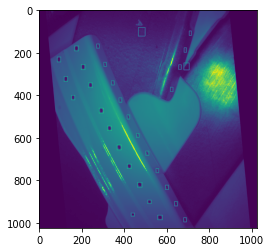

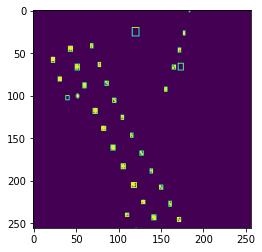

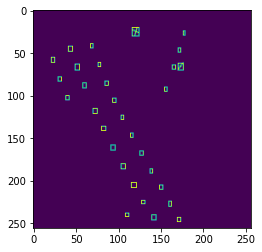

{'boxes': tensor([[679.1244, 975.6631, 692.7898, 995.4166],
        [636.3797, 899.5057, 650.4055, 920.9142],
        [593.8052, 822.0620, 608.3983, 843.0834],
        [549.4579, 744.4402, 562.3858, 764.2596],
        [501.8022, 662.1590, 516.3555, 682.7759],
        [457.1982, 579.1813, 470.4838, 598.1704],
        [413.2333, 492.5146, 426.7144, 512.5012],
        [375.0197, 412.8421, 389.4884, 433.7228],
        [339.4072, 332.3581, 353.2248, 352.3084],
        [304.3933, 245.8404, 316.5716, 265.7979],
        [270.9020, 159.3111, 283.6536, 179.9934],
        [432.6250, 953.2020, 448.1423, 968.6359],
        [557.7965, 963.9435, 579.0363, 985.6298],
        [510.2428, 892.0609, 527.7603, 909.9351],
        [462.1759, 809.9524, 484.4361, 832.1530],
        [414.2145, 723.3056, 433.9885, 744.4713],
        [366.5877, 633.9641, 386.9339, 657.5801],
        [322.7108, 544.1642, 340.8834, 566.5028],
        [282.9018, 460.8086, 302.4499, 484.9175],
        [152.6053, 400.1008, 168.5337, 4

In [30]:
#dValSet.dataset.bApplyTransform = False
dValSet.dataset.bApplyTransform = True
aImage, dTarget, aHeatMaps = dTestSet[2]

a = aImage[2,:,:].numpy()
b = aHeatMaps[0,:,:].numpy()
c = aHeatMaps[1,:,:].numpy()

lNewAnnotations = copy.deepcopy(dTarget)
lTargets = scaleBBoxAnnotations([lNewAnnotations], aImage.shape[1], aImage.shape[2], aHeatMaps.shape[1], aHeatMaps.shape[2])

addBBoxes(a, dTarget["boxes"],"", [1], True)
addBBoxes(b, lTargets[0]["boxes"],"", [1], True)
addBBoxes(c, lTargets[0]["boxes"],"", [1], True)

plt.imshow(a)
plt.show()

plt.imshow(b)
plt.show()

plt.imshow(c)
plt.show()

sDevice = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
aImage = aImage.to(sDevice)
print(dTarget)


In [261]:
with torch.no_grad():
    tReturned = mModel(aImage.unsqueeze(0))

In [262]:
torch.max(tReturned[0,0,:,:])

tensor(0.9263, device='cuda:0')

Pred:


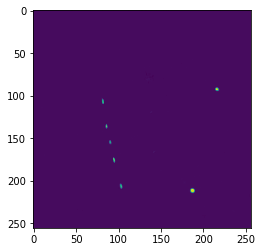

GT:


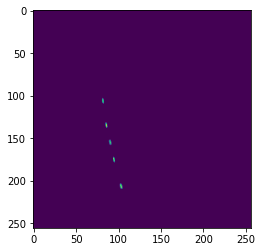

Pred:


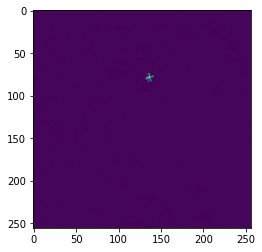

GT:


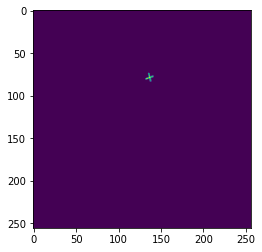

In [263]:
iClass = 0
a = tReturned.detach().cpu().numpy()[0,iClass,:,:]
print("Pred:")
plt.imshow(a)
plt.show()

print("GT:")
plt.imshow(aHeatMaps.numpy()[iClass,:,:])
plt.show()

iClass = 1
a = tReturned.detach().cpu().numpy()[0,iClass,:,:]
print("Pred:")
plt.imshow(a)
plt.show()

print("GT:")
plt.imshow(aHeatMaps.numpy()[iClass,:,:])
plt.show()


In [264]:
#cv2.imwrite("Heatmap0.tiff",tReturned[0,0,:,:].cpu().numpy())
#cv2.imwrite("Heatmap1.tiff",tReturned[0,1,:,:].cpu().numpy())

In [265]:
lNewAnnotations = copy.deepcopy(dTarget)
lTargets = scaleBBoxAnnotations([lNewAnnotations], aImage.shape[1], aImage.shape[2], aHeatMaps.shape[1], aHeatMaps.shape[2])
print(lTargets)

[{'boxes': tensor([[ 81., 104.,  83., 110.],
        [ 85., 133.,  87., 139.],
        [ 89., 153.,  91., 159.],
        [ 93., 173.,  96., 179.],
        [101., 203., 105., 210.],
        [131.,  72., 141.,  84.]]), 'labels': tensor([1, 1, 1, 1, 1, 2]), 'area': tensor([ 195.6061,  232.9094,  228.0579,  223.1050,  341.7607, 1987.1288]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'image_id': tensor([110])}]


In [266]:
lClasses = list(dTrainSet.dataset.dAnnotationClasses.keys())
lPredTargets = calculateBBoxesFromHeatMaps(tReturned.cpu().numpy(), lClasses)
lPredTargets

[{'boxes': tensor([[185., 209., 189., 214.],
          [102., 204., 103., 209.],
          [ 94., 174.,  95., 178.],
          [ 90., 153.,  90., 156.],
          [ 86., 134.,  86., 138.],
          [ 81., 105.,  82., 109.],
          [214.,  91., 217.,  94.],
          [132.,  74., 141.,  83.]], dtype=torch.float64),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 2]),
  'scores': tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000])}]

In [267]:
mMetric = MeanAveragePrecision(class_metrics=True)
mMetric.update(lPredTargets,lTargets)
dResults = mMetric.compute()
print(dResults)

{'map': tensor(0.2000), 'map_50': tensor(0.5000), 'map_75': tensor(0.), 'map_small': tensor(0.2000), 'map_medium': tensor(-1.), 'map_large': tensor(-1.), 'mar_1': tensor(0.2000), 'mar_10': tensor(0.2000), 'mar_100': tensor(0.2000), 'mar_small': tensor(0.2000), 'mar_medium': tensor(-1.), 'mar_large': tensor(-1.), 'map_per_class': tensor([0.0000, 0.4000]), 'mar_100_per_class': tensor([0.0000, 0.4000])}


In [22]:
import boto3

sm = boto3.client('sagemaker')
sm.stop_notebook_instance(NotebookInstanceName='fasterRCNNdataAugmentation')

ClientError: An error occurred (ValidationException) when calling the StopNotebookInstance operation: Notebook Instance arn:aws:sagemaker:eu-west-1:213935939005:notebook-instance/fasterrcnndataaugmentation does not exist